# Tutorial: Making image cutouts from Q1 data

<br>
<br>

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 

**Author(s):** Kristin Anett Remmelgas

**Last modified:** 14.03.2025

**Notebook summary**

This example notebook presents an example use case for making cutouts of Euclid images from Q1 data. We will be using the [Euclid Astroquery](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html) only for matching the sources with correct file names but accessing those files and making the cutouts is done on ESA Datalabs through the mounted Q1 data volume. Alternatively it is also possible to make cutouts through the archive instead (for example when running this notebook outside of Datalabs where there is no access to the data volume) - this is not covered in the notebook but the last section aims to give some pointers. The notebook shows how to make cutouts from both mosaic and calibrated frame products and the user can provide the sources they are interested in either manually, using and existing source file or by doing an archive query. Here are the steps:

1. Mosaic files 
    * Step 1.1: Creating a table of sources to make cutouts for
        * Creating the table manually (small amounts of sources)
        * Using an existing file with sources
        * Querying the catalogue for sources
    * Step 1.2: Getting the corresponding file for each source
    * Step 1.3: Making the cutouts
2. Calibrated frames
    * Step1: Querying for the sources you want to make cutouts for
    * Step2: Getting the corresponding file for each source
    * Step3: Making the cutouts


**Useful links:**

* [Q1 data release homepage](https://www.cosmos.esa.int/en/web/euclid/euclid-q1-data-release)
* [Euclid Q1 data product description](https://euclid.esac.esa.int/dr/q1/dpdd/index.html)
* [Euclid Astroquery documentation](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html)


**Running the notebook:** 

* This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. 
* The notebook uses functions from the **cutout_utils.py Python file**. When moving the notebook you need to move this file as well. You are welcome to modify the utility file for any custom/advanced behaviour you may need.
* The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included. 
* This notebook requires there to be a **cred.txt file** directly in your "my_workspace" folder for logging in to the Euclid Archive (see instructions in the "log in" section of the notebook).
***

<!-- ![image info](images/Euclid_logo.png) -->

In [1]:
# to make sure the cutout_utils.py file is updated here after every change
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary packages
from astroquery.esa.euclid.core import EuclidClass
import cutout_utils as ut
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy.table import Table
import matplotlib.image as mpimg
from astropy.io import fits
from matplotlib import rcParams
from skimage import io
import glob
import os

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)

### Creating output folder for the cutouts

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace called: `'example_notebook_outputs/'`

In [3]:
#making a folder for the future cutouts (if not made already)
cutout_folder= '/media/user/example_notebook_outputs/cutouts/'
if not os.path.exists(cutout_folder):
    os.makedirs(cutout_folder)

### Choosing the archive environment

Next step is choosing the archive environment you want to work with. We will be using the PDR environment which stands for "Public Data Release".

In [4]:
#choosing the archive envionment
Euclid = EuclidClass(environment='PDR')

### Log in

**It is only possible to run this notebook after you have included a cred.txt file directly into your "my_workspace" folder**. This file is used to login to the Astroquery in this notebook and **also** in the python file cutout_utils.py that this notebook uses. The file should contain 2 lines - one for your username and the other for your password. Putting the file in your workspace ensures that only you can see it.

In the cell below you can see how to log in to the Euclid archive environment using the credentials file. Similarly to the archive website for safety reasons this login expires after a period of time. Once this happens the queries to the archive will fail (seemingly without reason). If you are running a personal notebook that requires you to stay logged in for longer - make sure to execute this code line again every once in a while. 

In [5]:
Euclid.login(credentials_file = '/media/user/cred.txt')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


# 1. Mosaics
## 1.1 Getting sources to make cutouts for

The first step is to create a table of sources to start making cutouts for. We will look at 3 possible ways to make this table. The third option is the default (others are commented out) because it does not require any user action but you are welcome to follow the instructions to use the option that works best for you.

* Creating a source table manually (for small amounts of sources)
* Getting a source table from an existing file
* Creating a source table by querying the catalogue

This source table will later be used as part of an ADQL query and in order to do that we need to upload the table as a user_table through Astroquery for the first two options. Since the third option is an ADQL query as well then we can just combine them and the upload step is not necessary.

### Creating a source table manually

In this example we will manually create an Astropy table of sources. The table will only have two columns for each source: "right_ascension" and "declination". For the next steps to work the columns have to be called either that or "ra" and "dec". The table is created from a list of ra and dec coordinates. As a helper function we also demonstrate how to query Simbad for the coordinates of a source by name and then use these coordinates in our table.

In [6]:
# creating Astropy table
# simbad_out = Simbad.query_object('NGC6505')
# ra = [simbad_out['ra'][0], 275.790900]
# dec = [simbad_out['dec'][0], 67.134113]

# source_table = Table([ra, dec], names=('right_ascension', 'declination'))
# source_table

We now upload the table to your user area as a user table. If you want you can see your user tables on the [archive website](https://eas.esac.esa.int/sas/) under Search -> ADQL form -> User tables. Note that if you already have a table with this name then the line below will give an error and you should change the name.

In [7]:
# Euclid.upload_table(upload_resource=source_table, table_name='my_sources')

### Getting sources from an existing user file

The second option for creating a source table is using sources in an existing file that you may have. The source table in your file needs to have columns called either "right_ascension" and "declination" or "ra" and "dec" for the source coordinates. It may have any number of other columns as well. This option requires some user interaction from your side. In order to use a file you already have you first need to upload it to ESA Datalabs and then in the cells below provide a path to where you uploaded your file. In case it is a csv file you can directly upload it as a user table as shown in the next cell.

In [8]:
# in case of csv file: upload file as user table directly
# user_filepath = "/media/user/example_notebook_outputs/async_result.csv"
# Euclid.upload_table(upload_resource=user_filepath, table_name="my_sources_from_file", format='csv')

In the future the same method would work for fits files as well but for now we need to read them into an astropy table in this notebook and then upload the astropy table as a user table (like in the first manual option). Or alternatively you can upload the fits file as a user table through the [archive website](https://eas.esac.esa.int/sas/).

In [9]:
# in case of fits file: read in the file and then upload the astropy table as user table
# user_filepath = "/media/user/example_notebook_outputs/async_result.fits"
# with fits.open(user_filepath) as hdul:
#     source_table_from_file = Table(hdul[1].data)
# source_table_from_file

In [10]:
# Euclid.upload_table(upload_resource=source_table_from_file, table_name='my_sources_from_file')

### Getting sources from a catalogue query - default

In the third option we are creating a table of sources by querying the Euclid MER catalogue for sources matching a certain criteria. Please make sure your query has brackets around it (as it will be used as a part of a bigger query in the next step) and contains right_ascension and declination as column names (currently the rest of the code won't work if you change the names). Also if the sources that you would like to make cutouts for are from the MER catalogue be sure to include the column segmentation_map_id in your query - this allows for matching the sources to their corresponding files faster in the next step.

In [11]:
#coming up with a suitable query
query = """(SELECT right_ascension, declination, segmentation_area, flux_vis_1fwhm_aper, ellipticity, kron_radius, segmentation_map_id
        FROM catalogue.mer_catalogue
        WHERE segmentation_area < 6100 AND segmentation_area > 5500 AND flux_vis_1fwhm_aper > 20 AND flux_vis_1fwhm_aper < 100)"""

job = Euclid.launch_job_async(query)
#adding an order/sorting for easier comparison with other tables later
df_sources = job.get_results().to_pandas().sort_values("right_ascension", ascending= False, ignore_index=True)

print("Found", len(df_sources), " query results")
df_sources[:10]

INFO: Query finished. [astroquery.utils.tap.core]
Found 1216  query results


,right_ascension,declination,segmentation_area,flux_vis_1fwhm_aper,ellipticity,kron_radius,segmentation_map_id
0,276.318951,65.556223,5673,26.892618,0.047113,82.092758,102158897006076
1,276.284770,66.910966,5819,24.947716,0.602715,163.485245,102159780032162
2,276.276815,66.882078,5501,30.039425,0.146957,90.297577,102159780026630
3,276.209017,65.537707,5664,24.417110,0.028561,87.274590,102158896062579
4,275.947640,65.690940,5978,30.283392,0.225634,97.587631,102158896095941
5,275.912586,65.380152,5691,30.137297,0.169066,75.342842,102158896026920
6,275.888040,66.631419,5534,28.700020,0.121985,78.456581,102159491074918
7,275.878287,66.504138,6063,21.460257,0.163442,95.899162,102159491050302
8,275.809695,66.468245,6082,35.867321,0.589668,145.684021,102159491043596
9,275.790900,67.134113,5764,20.360670,0.615101,144.266434,102159780064742


## 1.2 Getting corresponding files 

The next step is to find corresponding files to make cutouts from for each of the sources in your source table. To do this we have provided a function called `getFiles` in the cutout_util.py helper file that is used in the cell below. As mentioned before the sources can be provided either as the query constructed in the cell above (third option) or using a custom user table you have uploaded as a user table (first and second option). Here is a quick overview of the function parameters:

* product_type (str, mandatory)- type of files you want to make cutouts from. Either mosaic or calibrated_frame
* sources (str, mandatory) - either the query constructed above as str or the name of the uploaded user table (see example)
* instrument_name (str) - either 'VIS' or 'NISP' (specifying NISP will obtain files for all 3 bands unless nisp_filters parameter specified)
* nisp_filters (list, optional) - list containing any or all of the NISP filter names you want NIR_H, NIR_J, NIR_Y
* segmentation_map_id (bool, optional)- whether your source table has this column (enables faster file matching for mosaics, default False)

**What is segmentation_map_id?**

The segmentation_map_id is one of the columns in the MER source catalogue and the first 9 characters of it give the index of the tile where the source was extracted from. This way we can find the correct file directly otherwise we would match with all files that have the source in the field of view and then (in case there are multiple) choose the one where the source is the closest to the image centre.

**Result table**

The result of this getFiles function is a table where the first half of each line is the source information from before and the second half is the file information (obtained from sedm.mosaic_product data table) that will later be used to make a cutout. For VIS there is exactly one line per source but for NISP the same source info will appear 3 times with 3 different file infos (for each of the bands). In the cell below we also sort the table as the last step. This is only necessary so the user can visually compare the table with only sources (from the query) and the resulting table with matching files. For doing the cutouts in the next step the order of the table does not matter so this step can also be removed to save time.

**Note: Paths**

In the result table below the column called 'datalabs_path' shows the directory of the file in the Q1 volume mounted in ESA Datalabs. We will be using this path combined with the filename to access the data. The 'file_path' column is the directory of the data in the SAS archives. They are similar but not exactly the same.

In [12]:
# example 1: query option with VIS files
df_sources_w_files = ut.getFiles(product_type = "mosaic", sources=query, instrument_name='VIS', segmentation_map_id = True)

# example 2: user table option with 2 NISP bands
# user_table = "user_yourusername.yourtablename" # (e.g. "user_johnsmith.mysources")
# df_sources_w_files = ut.getFiles(product_type = "mosaic", sources=user_table, instrument_name='NISP', nisp_filters = ['NIR_H', 'NIR_Y'], segmentation_map_id = False)

#sorting the table like before for visual comparison
ra_colname = "ra" if "ra" in list(df_sources_w_files.columns) else "right_ascension"
df_sources_w_files = df_sources_w_files.sort_values(ra_colname, ascending= False, ignore_index=True)
df_sources_w_files[:10]

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Found 1216 query results


,right_ascension,declination,segmentation_area,flux_vis_1fwhm_aper,segmentation_map_id,kron_radius,ellipticity,file_name,file_path,datalabs_path,mosaic_product_oid,tile_index,instrument_name,filter_name,image_ra,image_dec,dist
0,276.318951,65.556223,5673,26.892618,102158897006076,82.092758,0.047113,EUC_MER_BGSUB-MOSAIC-VIS_TILE102158897-2E1DE9_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215889...,/data/euclid_q1/Q1_R1/MER/102158897/VIS,2263,102158897,VIS,VIS,276.845585,65.50080,0.225082
1,276.284770,66.910966,5819,24.947716,102159780032162,163.485245,0.602715,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159780-FE8755_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215978...,/data/euclid_q1/Q1_R1/MER/102159780/VIS,1841,102159780,VIS,VIS,275.862713,67.00000,0.187675
2,276.276815,66.882078,5501,30.039425,102159780026630,90.297577,0.146957,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159780-FE8755_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215978...,/data/euclid_q1/Q1_R1/MER/102159780/VIS,1841,102159780,VIS,VIS,275.862713,67.00000,0.200530
3,276.209017,65.537707,5664,24.417110,102158896062579,87.274590,0.028561,EUC_MER_BGSUB-MOSAIC-VIS_TILE102158896-4A7F11_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215889...,/data/euclid_q1/Q1_R1/MER/102158896/VIS,2273,102158896,VIS,VIS,275.662484,65.49535,0.230426
4,275.947640,65.690940,5978,30.283392,102158896095941,97.587631,0.225634,EUC_MER_BGSUB-MOSAIC-VIS_TILE102158896-4A7F11_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215889...,/data/euclid_q1/Q1_R1/MER/102158896/VIS,2273,102158896,VIS,VIS,275.662484,65.49535,0.228340
5,275.912586,65.380152,5691,30.137297,102158896026920,75.342842,0.169066,EUC_MER_BGSUB-MOSAIC-VIS_TILE102158896-4A7F11_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215889...,/data/euclid_q1/Q1_R1/MER/102158896/VIS,2273,102158896,VIS,VIS,275.662484,65.49535,0.155173
6,275.888040,66.631419,5534,28.700020,102159491074918,78.456581,0.121985,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159491-465A24_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215949...,/data/euclid_q1/Q1_R1/MER/102159491/VIS,2047,102159491,VIS,VIS,275.362454,66.50000,0.246904
7,275.878287,66.504138,6063,21.460257,102159491050302,95.899162,0.163442,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159491-465A24_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215949...,/data/euclid_q1/Q1_R1/MER/102159491/VIS,2047,102159491,VIS,VIS,275.362454,66.50000,0.205712
8,275.809695,66.468245,6082,35.867321,102159491043596,145.684021,0.589668,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159491-465A24_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215949...,/data/euclid_q1/Q1_R1/MER/102159491/VIS,2047,102159491,VIS,VIS,275.362454,66.50000,0.181254
9,275.790900,67.134113,5764,20.360670,102159780064742,144.266434,0.615101,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159780-FE8755_...,/euclid/repository_idr/iqr1/Q1_R1/MER/10215978...,/data/euclid_q1/Q1_R1/MER/102159780/VIS,1841,102159780,VIS,VIS,275.862713,67.00000,0.137001


### Checking if there were sources that don't have a matching file

There are some sources that exist in the MER catalogue that might not have an existing mosaic tile at all. These sources automatically do not appear in the table that includes files. In the next cell we double check if this has occurred and for which sources by comparing the initial source table to the one with files.

Note: when using an uploaded custom source table please ignore this part for now

In [13]:
dif_ra = list(set(df_sources['right_ascension']) - set(df_sources_w_files['right_ascension']))
print("Found", len(dif_ra), "sources without a matching mosaic file")
df_sources[df_sources['right_ascension'].isin(dif_ra)]

Found 0 sources without a matching mosaic file


,right_ascension,declination,segmentation_area,flux_vis_1fwhm_aper,ellipticity,kron_radius,segmentation_map_id


## 1.3 Making the cutouts

As the next step we iterate over the table with files and for each line make a cutout using the file path and name. For this we have created a function called `makeCutoutsByTile` in the cutout_utils.py file and here is a quick overview of the function parameters:

* df (mandatory) - table that includes sources and their file info - output of getFiles function
* output_location (mandatory) - path where to store the cutouts
* cutout_size (mandatory) - input size to [astropy.Cutout2D](https://docs.astropy.org/en/stable/api/astropy.nddata.utils.Cutout2D.html). Can be anything astropy Cutout2D allows or in case you want variable cutout size the name of the column from the source table that the cutout size should depend on (see example)
* cutout_func (mandatory if cutout_size is string)- in case of variable cutout size this is the name of a user defined function how the size depends on the selected column
* optional_cutout_params (optional) - other inputs to [astropy.Cutout2D](https://docs.astropy.org/en/stable/api/astropy.nddata.utils.Cutout2D.html) like mode and fill value. The default mode is trim so when a source is on the edge of the image the cutout will be smaller.
* resize_params (optional) - in case you want to resize the cutout before saving it then the inputs to [skimage resize](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize). By default no resizing is done.


In case you want the cutouts to have variable size depending on one of the source parameters then the source table created in the first step of the notebook needs to have that parameter as a column. The example below will use kron_radius.

Note that the order of making the cutouts will not be the same as the order of sources/files in the table. All the sources that are on the same file will be done together so each file only needs to be read in once.

In [14]:
# example 1: 0.2 arcmin square cutouts
ut.makeCutoutsByTile(df_sources_w_files[:10], output_location = cutout_folder, cutout_size = 0.2 * u.arcmin)

# example 2: 20 x 30 pixel rectangular cutouts
# ut.makeCutoutsByTile(df_sources_w_files[:10], output_location = cutout_folder, cutout_size = (20, 30))

# example 3: variable cutout size - the cutout size is dependent on the kron_radius of the source using a user-defined function
# in this case cutout size will be source kron_radius * 0.2 / 195 u.arcmin
# def func(x):
#     return x * 0.2 / 195 * u.arcmin
# ut.makeCutoutsByTile(df_sources_w_files[:10], output_location = cutout_folder, cutout_size = 'kron_radius', cutout_func=func)

# example 4: adding more cutout options (default mode is 'trim' with no fill value - the cutouts will differ in size)
# cut_params = {'mode': 'partial', 'fill_value': None}
# ut.makeCutoutsByTile(df_sources_w_files[:10], output_location = cutout_folder, cutout_size = 0.2 * u.arcmin, optional_cutout_params=cut_params)

# example 5: adding parameters for resizing the cutout
# params = {'output_shape': (50, 50), 'order': None, 'mode': 'reflect', 'cval': 0, 'clip': True, 'preserve_range': False, 'anti_aliasing': None, 'anti_aliasing_sigma': None}
# ut.makeCutoutsByTile(df_sources_w_files[:10], output_location = cutout_folder, cutout_size = 'kron_radius', cutout_func=func, resize_params=params)

Number of files processed:   0%|          | 0/4 [00:00<?, ?it/s]

Made cutout MOSAIC-VIS_TILE102158896-CUTOUT_276.209017_65.5377075.fits
Made cutout MOSAIC-VIS_TILE102158896-CUTOUT_275.94764_65.6909397.fits
Made cutout MOSAIC-VIS_TILE102158896-CUTOUT_275.9125856_65.3801518.fits
Made cutout MOSAIC-VIS_TILE102158897-CUTOUT_276.3189515_65.5562226.fits
Made cutout MOSAIC-VIS_TILE102159491-CUTOUT_275.8880403_66.6314193.fits
Made cutout MOSAIC-VIS_TILE102159491-CUTOUT_275.8782875_66.5041378.fits
Made cutout MOSAIC-VIS_TILE102159491-CUTOUT_275.8096949_66.4682446.fits
Made cutout MOSAIC-VIS_TILE102159780-CUTOUT_276.2847702_66.910966.fits
Made cutout MOSAIC-VIS_TILE102159780-CUTOUT_276.2768148_66.8820785.fits
Made cutout MOSAIC-VIS_TILE102159780-CUTOUT_275.7909005_67.1341127.fits
Created a total of 10 cutouts


### Looking at the cutouts

Here we take a quick look at some of the cutouts we have made

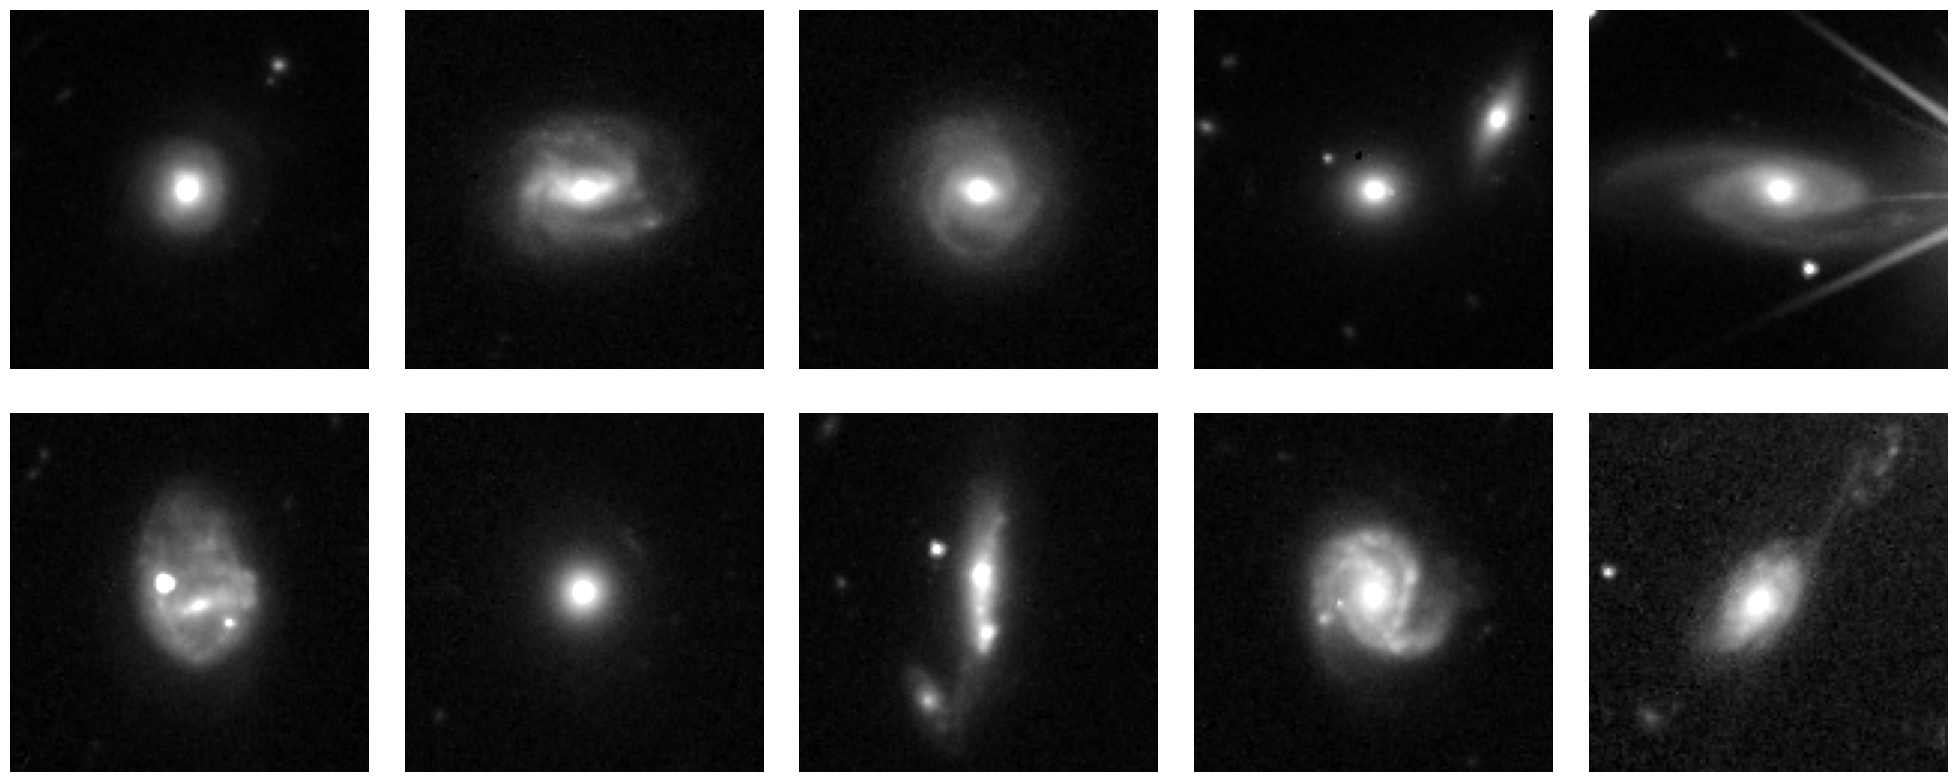

In [15]:
#showing 10 of the cutouts
files = sorted(glob.glob(cutout_folder + "*MOSAIC-VIS*.fits")) #for mosaic VIS files
# files = sorted(glob.glob(cutout_folder + "*MOSAIC-NIR*.fits")) #for mosaic NISP files

_, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for ax, img_path in zip(axes.flatten(), files):
    image_data = fits.getdata(img_path, ext=0)
    ax.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.5), stretch=AsinhStretch()))
    ax.axis("off")

# 2. Calibrated frames

This part of the notebook shows how to make cutouts for calibrated frames - the steps and used functions are all the same as before but things are happening a bit differently in the cutout_utils.py backend when it comes to calibrated frames. To give a bit of context below is an example of a Euclid calibrated nisp frame. As you can see it is divided into 4x4 detectors with gaps between them. On a file level these detectors are all different extensions of a fits file. This means that when making a cutout we first have to select which detector we are going to cut. 

Another difference to mosaic files is that there is no shortcut (segmentation_map_id) that can be used to match sources to files so we have to do that using the alternate approach of checking whether the source is in the field of fiew of the image.

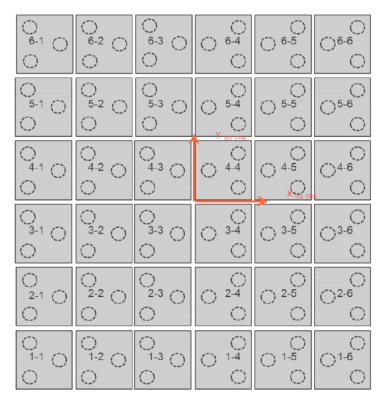

In [16]:
rcParams['figure.figsize'] = [5.,5.]
image = io.imread("http://st-dm.pages.euclid-sgs.uk/data-product-doc/dmq1/_images/CCD_numbering1.png")
plt.imshow(image)
plt.axis('off');

### Coming up with a suitable query

Using a similar query as before. If the query fails always make sure you are still logged in.

In [17]:
#coming up with a suitable query
query = """(SELECT right_ascension, declination, segmentation_area, flux_vis_1fwhm_aper, ellipticity, kron_radius, segmentation_map_id
        FROM catalogue.mer_catalogue
        WHERE segmentation_area < 6100 AND segmentation_area > 5500 AND flux_vis_1fwhm_aper > 20 AND flux_vis_1fwhm_aper < 100)"""

job = Euclid.launch_job(query)
#adding an order/sorting for easier comparison with other tables later
df_sources = job.get_results().to_pandas().sort_values("right_ascension", ascending= False, ignore_index=True)
print("Found", len(df_sources), " query results")
df_sources[:10]

Found 1216  query results


,right_ascension,declination,segmentation_area,flux_vis_1fwhm_aper,ellipticity,kron_radius,segmentation_map_id
0,276.318951,65.556223,5673,26.892618,0.047113,82.092758,102158897006076
1,276.284770,66.910966,5819,24.947716,0.602715,163.485245,102159780032162
2,276.276815,66.882078,5501,30.039425,0.146957,90.297577,102159780026630
3,276.209017,65.537707,5664,24.417110,0.028561,87.274590,102158896062579
4,275.947640,65.690940,5978,30.283392,0.225634,97.587631,102158896095941
5,275.912586,65.380152,5691,30.137297,0.169066,75.342842,102158896026920
6,275.888040,66.631419,5534,28.700020,0.121985,78.456581,102159491074918
7,275.878287,66.504138,6063,21.460257,0.163442,95.899162,102159491050302
8,275.809695,66.468245,6082,35.867321,0.589668,145.684021,102159491043596
9,275.790900,67.134113,5764,20.360670,0.615101,144.266434,102159780064742


### Getting corresponding files 

Note that the resulting table below contains all the calibrated frames where the specific source is in the fov of the image. When matching sources with files we make a circle with a default size of 0.5 arcmin centered on the source coordinates and return files where this area is fully in the file fov of the image. Because of the nature of calibrated frames this however does not mean that it is possible to make a cutout of that source from all of those images because the images also contain gaps between the detectors. So when the source is in the gap no cutout is made - that is why the resulting number of cutouts will be less than the number of files in this table.

In [18]:
# example 1: query option with NISP files
df_sources_w_files_calib = ut.getFiles(product_type = "calibrated_frame", sources=query, instrument_name='NISP', nisp_filters = ['NIR_H'])

# example 2: user table option with VIS files
# user_table = "user_yourusername.yourtablename" # (e.g. "user_johnsmith.mysources")
# df_sources_w_files_calib = ut.getFiles(product_type = "calibrated_frame", sources=user_table, instrument_name='VIS')

#sorting the table like before for visual comparison
ra_colname = "ra" if "ra" in list(df_sources_w_files_calib.columns) else "right_ascension"
df_sources_w_files_calib = df_sources_w_files_calib.sort_values(ra_colname, ascending= False, ignore_index=True)
df_sources_w_files_calib[:10]

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Found 5158 query results


,right_ascension,declination,segmentation_area,flux_vis_1fwhm_aper,segmentation_map_id,kron_radius,ellipticity,file_name,file_path,datalabs_path,instrument_name,filter_name,observation_id,image_ra,image_dec,dist
0,276.318951,65.556223,5673,26.892618,102158897006076,82.092758,0.047113,EUC_NIR_W-CAL-IMAGE_H-2716-2_20240930T195842.2...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.267542,65.619484,0.439120
1,276.318951,65.556223,5673,26.892618,102158897006076,82.092758,0.047113,EUC_NIR_W-CAL-IMAGE_H-2716-3_20240930T195841.8...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.352624,65.617438,0.404056
2,276.284770,66.910966,5819,24.947716,102159780032162,163.485245,0.602715,EUC_NIR_W-CAL-IMAGE_H-2699-3_20240930T180736.2...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2699,/data/euclid_q1/Q1_R1/NIR/2699,NISP,NIR_H,2699,275.802342,66.485716,0.466103
3,276.276815,66.882078,5501,30.039425,102159780026630,90.297577,0.146957,EUC_NIR_W-CAL-IMAGE_H-2699-2_20240930T180736.2...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2699,/data/euclid_q1/Q1_R1/NIR/2699,NISP,NIR_H,2699,275.714346,66.488024,0.452585
4,276.276815,66.882078,5501,30.039425,102159780026630,90.297577,0.146957,EUC_NIR_W-CAL-IMAGE_H-2699-3_20240930T180736.2...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2699,/data/euclid_q1/Q1_R1/NIR/2699,NISP,NIR_H,2699,275.802342,66.485716,0.438598
5,276.209017,65.537707,5664,24.417110,102158896062579,87.274590,0.028561,EUC_NIR_W-CAL-IMAGE_H-2716-1_20240930T195841.9...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.200156,65.606197,0.422794
6,276.209017,65.537707,5664,24.417110,102158896062579,87.274590,0.028561,EUC_NIR_W-CAL-IMAGE_H-2716-3_20240930T195841.8...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.352624,65.617438,0.362947
7,276.209017,65.537707,5664,24.417110,102158896062579,87.274590,0.028561,EUC_NIR_W-CAL-IMAGE_H-2716-2_20240930T195842.2...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.267542,65.619484,0.397741
8,275.947640,65.690940,5978,30.283392,102158896095941,97.587631,0.225634,EUC_NIR_W-CAL-IMAGE_H-2716-2_20240930T195842.2...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.267542,65.619484,0.289316
9,275.947640,65.690940,5978,30.283392,102158896095941,97.587631,0.225634,EUC_NIR_W-CAL-IMAGE_H-2716-3_20240930T195841.8...,/euclid/repository_idr/iqr1/Q1_R1/NIR/2716,/data/euclid_q1/Q1_R1/NIR/2716,NISP,NIR_H,2716,275.352624,65.617438,0.256065


### Making the cutouts

Other than choosing the correct detector for making the cutout this part works the same as before.

In [19]:
# example 1: 0.2 arcmin square cutouts
ut.makeCutoutsByTile(df_sources_w_files_calib[:15], output_location = cutout_folder, cutout_size = 0.2 * u.arcmin)

# example 2: 20x30 pixel rectangular cutouts
# ut.makeCutoutsByTile(df_sources_w_files_calib[:10], output_location = cutout_folder, cutout_size = (20, 30))

# example 3: the cutout radius becomes dependent on the kron_radius of the source
# def func(x):
#     return x * 0.2 / 195 * u.arcmin
# ut.makeCutoutsByTile(df_sources_w_files_calib[:10], output_location = cutout_folder, cutout_size = 'kron_radius', cutout_func=func)

# example 4: adding more cutout options (default mode is 'trim' with no fill value - the cutouts will differ in size)
# cut_params = {'mode': 'partial', 'fill_value': None}
# ut.makeCutoutsByTile(df_sources_w_files_calib[:10], output_location = cutout_folder, cutout_size =  0.2 * u.arcmin, optional_cutout_params=cut_params)

# example 5: adding parameters for resizing the cutout
# params = {'output_shape': (50, 50), 'order': None, 'mode': 'reflect', 'cval': 0, 'clip': True, 'preserve_range': False, 'anti_aliasing': None, 'anti_aliasing_sigma': None}
# ut.makeCutoutsByTile(df_sources_w_files_calib[:10], output_location = cutout_folder, cutout_size = 'kron_radius', cutout_func=func, resize_params=params)

Number of files processed:   0%|          | 0/6 [00:00<?, ?it/s]

Made cutout NIR_W-CAL-IMAGE_H-2699-2-CUTOUT_276.2768148_66.8820785.fits
Made cutout NIR_W-CAL-IMAGE_H-2699-3-CUTOUT_276.2847702_66.910966.fits
Made cutout NIR_W-CAL-IMAGE_H-2699-3-CUTOUT_276.2768148_66.8820785.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-0-CUTOUT_275.94764_65.6909397.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-1-CUTOUT_276.209017_65.5377075.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-1-CUTOUT_275.94764_65.6909397.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-1-CUTOUT_275.9125856_65.3801518.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-2-CUTOUT_276.3189515_65.5562226.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-2-CUTOUT_276.209017_65.5377075.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-2-CUTOUT_275.94764_65.6909397.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-2-CUTOUT_275.9125856_65.3801518.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-3-CUTOUT_276.3189515_65.5562226.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-3-CUTOUT_276.209017_65.5377075.fits
Made cutout NIR_W-CAL-IMAGE_H-2716-3-CUTOUT_275.94764_65.6909397.fits
Made

### Looking at the cutouts

Here we take a quick look at some of the cutouts we have made

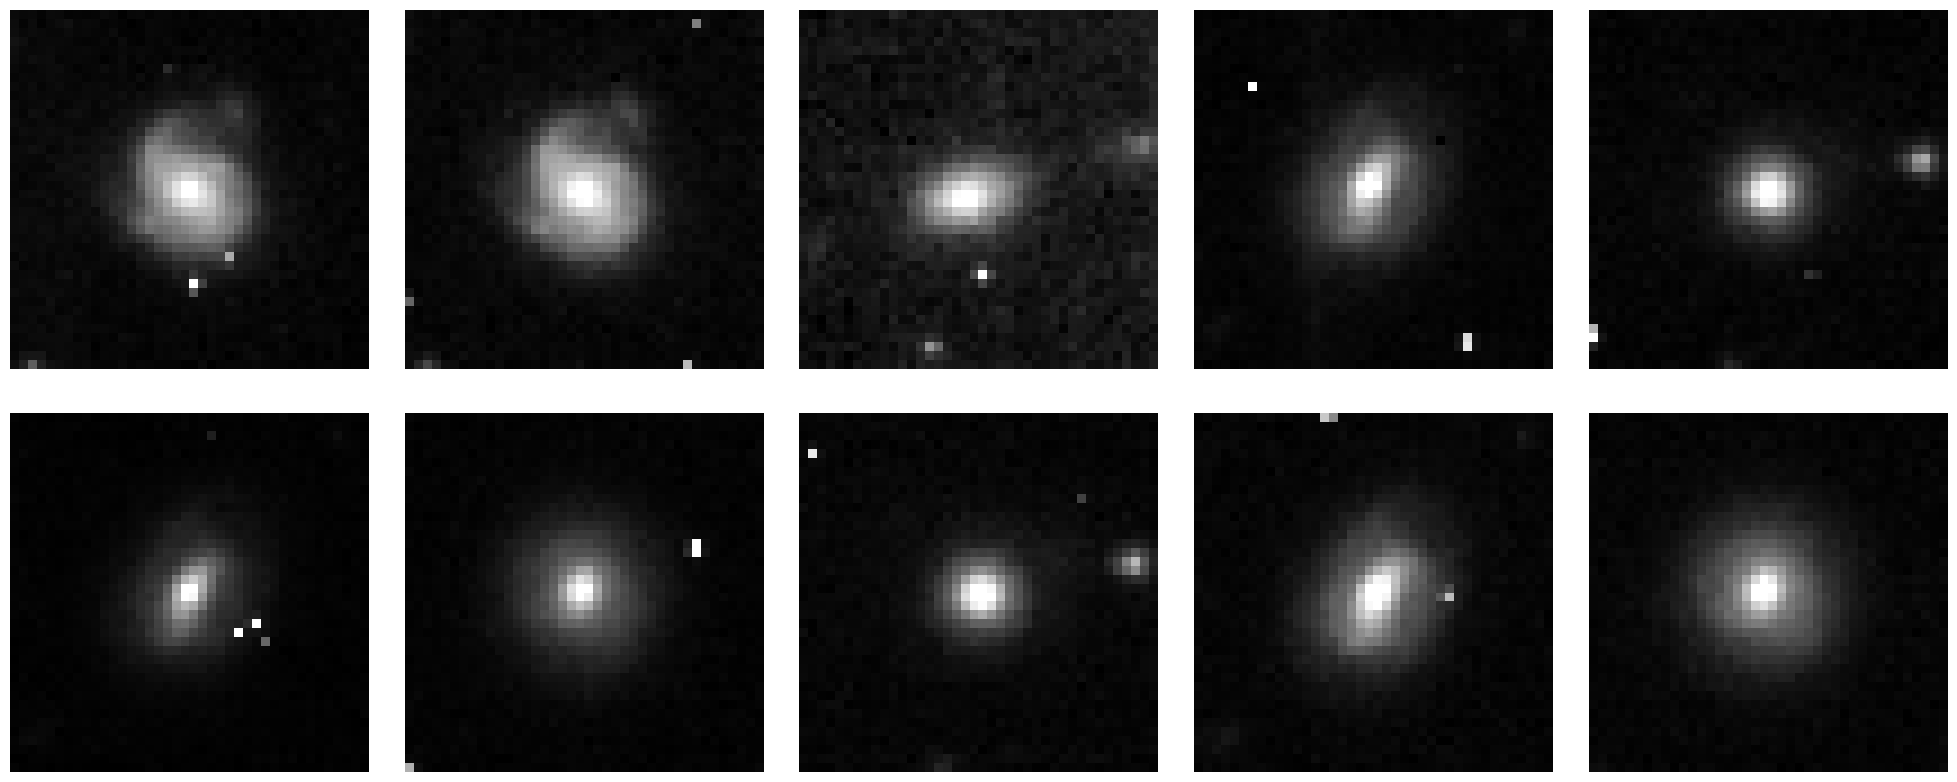

In [20]:
#showing 10 of the cutouts
files = sorted(glob.glob(cutout_folder + "*NIR_W-CAL*.fits")) #for calibrated NISP files
# files = sorted(glob.glob(cutout_folder + "*VIS_SWL*.fits")) #for calibrated VIS files

_, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for ax, img_path in zip(axes.flatten(), files):
    image_data = fits.getdata(img_path, ext=0)
    ax.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.5), stretch=AsinhStretch()))
    ax.axis("off")

***

**Runnning the notebook outside of ESA Datalabs**

The current notebook was developed with the intent to use it inside ESA Datalabs, so all the filepaths point to the data volume mounted in ESA Datalabs. This section aims to provide some pointers for making (bulk) image cutouts outside of the platform. These are the two main things to consider:

1. You need to install all the packages used in the notebook yourself
2. When trying to access any of the data outside of the platform it needs to be done through the archive with Astroquery

Regarding the second point Astroquery method get_cutout() can be used to make cutouts through the archive (compared to Astropy cutout2d function used in the notebook). One of the main difference between using the functions is that Astroquery requires a data path to the file location in the archive. This path is not exactly the same as the path in ESA Datalabs but similar. For example:

* ESA Datalabs path: `/data/euclid_q1/Q1_R1/MER/102158897/VIS/filename.fits`
* Archive path: `/euclid/repository_idr/iqr1/Q1_R1/MER/102158897/VIS/filename.fits`

Notice how the second half of the data path stays the same. Some data tables on the archive (for example mosaic_product) store both of these paths. The archive path is stored in a column called `file_path` and ESA Datalabs path in a column `datalabs_path`. So when making a query for products you can include the column you are interested in. Here is a small illustrative example of how you can use the get_cutout function. For more information take a look at the [Astroquery examples notebook](Astroquery.ipynb).

```python
filepath = '/data/euclid_q1/Q1_R1/MER/102158897/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits'

saved_cutout_filepath = Euclid.get_cutout(
                        file_path = filepath, 
                        instrument = "VIS", 
                        id = "101158889", 
                        coordinate = SkyCoord("17h51m07.4s +65d31m50.8s", frame='icrs'),
                        radius = 0.2 * u.arcmin, 
                        output_file = output_folder + 'test_cutout_example.fits')
```